In [1]:
import os
import torch
import GPUtil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

from vecopsciml.operators.zero_order import Mx, My
from utils.checkpoints import load_results

In [2]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/sigmoid_nonlinear/sigmoid_nonlinear.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'transfer_learning/results/sigmoid_no_training_decoder')

MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/non_linear_1000_0/model_autoencoder_AE_10')
MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/non_linear_1000_0/model_autoencoder_NN_10')
MODEL_RESULTS_TRANSFERLEARNING_PATH = os.path.join(ROOT_PATH, r'transfer_learning/results/sigmoid_no_training_decoder')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_AE_PATH)
create_folder(MODEL_RESULTS_PGNNIV_PATH)

Folder successfully created at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/transfer_learning/results/sigmoid_no_training_decoder
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_1000_0/model_autoencoder_AE_10
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear_1000_0/model_autoencoder_NN_10


In [3]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/sigmoid_nonlinear/sigmoid_nonlinear.pkl


In [4]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


### División de los datos

In [6]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = torch.Tensor(dataset['y_train']).unsqueeze(1)
K_train = torch.tensor(dataset['k_train']).unsqueeze(1)
f_train = torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.Tensor(dataset['y_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 80
Validation dataset length: 20


In [7]:
X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X_train, y_train, K_train, f_train, test_size=0.2, random_state=42)

X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

## Autoencoder

In [8]:
from model import Autoencoder as PretrainedAutoencoder
from model.ae_nonlinear_model import AutoencoderNonlinearModel as PretrainedPGNNNIV
from model.transfer_learnign_ae import AutoencoderTransferLearning as TransferLearningAutoencoder
from trainers.train import train_autoencoder_loop

In [9]:
from vecopsciml.operators.zero_order import Mx, My
from model.ae_nonlinear_model import AutoencoderNonlinearModel

In [10]:
# Other parameters
n_filters_explanatory = 5
n_modes = 10

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10]
explanatory_output = Mx(My(f_train)).values[0].shape


In [11]:
# Load autoencoder
autoencoder_input_shape = y_train.values[0].shape
latent_space_dim = [20, 10, n_modes, 10, 20]
autoencoder_output_shape = y_train.values[0].shape

pretrained_autoencoder = PretrainedAutoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
optimizer = torch.optim.Adam(pretrained_autoencoder.parameters(), lr=1e-4)
pretrained_autoencoder, optimizer, lists = load_results(pretrained_autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

In [12]:
# Load pretrained PGNNIV
pretrained_encoder = pretrained_autoencoder.encoder
pretrained_decoder = pretrained_autoencoder.decoder

pretrained_pgnniv = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                        explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(pretrained_pgnniv.parameters(), lr=1e-4)
pretrained_pgnniv, optimizer, lists = load_results(pretrained_pgnniv, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

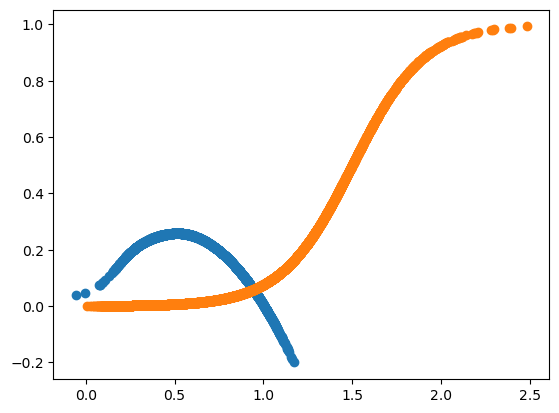

In [13]:
plt.scatter(Mx(My(TensOps(pretrained_pgnniv(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            pretrained_pgnniv(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())

In [14]:
pgnniv_pretrained_encoder = pretrained_pgnniv.encoder

for param in pgnniv_pretrained_encoder.parameters():
    param.requires_grad = False

for name, param in pgnniv_pretrained_encoder.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

hidden1_layer.weight: requires_grad=False
hidden1_layer.bias: requires_grad=False
hidden2_layer.weight: requires_grad=False
hidden2_layer.bias: requires_grad=False
latent_space_layer.weight: requires_grad=False
latent_space_layer.bias: requires_grad=False


In [15]:
# explanatory_layers = [100]

model = TransferLearningAutoencoder(input_shape, predictive_layers, pgnniv_pretrained_encoder, predictive_output, explanatory_input,
                                   explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parametros de entrenamiento
start_epoch = 0
n_epochs = 50000

batch_size = 64
n_checkpoints = 10

train_loop(model, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
           D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE)

Starting training from scratch.
Epoch 0, Train loss: 2.798e+12, Test loss: 3.032e+12, MSE(e): 1.090e+02, MSE(pi1): 1.683e+05, MSE(pi2): 4.762e+01, MSE(pi3): 2.534e+02
Epoch 100, Train loss: 4.611e+11, Test loss: 6.897e+11, MSE(e): 4.316e+01, MSE(pi1): 2.379e+03, MSE(pi2): 1.500e+01, MSE(pi3): 5.692e+01
Epoch 200, Train loss: 1.877e+11, Test loss: 2.858e+11, MSE(e): 1.747e+01, MSE(pi1): 1.056e+03, MSE(pi2): 6.250e+00, MSE(pi3): 2.396e+01
Epoch 300, Train loss: 1.269e+11, Test loss: 1.710e+11, MSE(e): 1.230e+01, MSE(pi1): 2.845e+02, MSE(pi2): 5.140e+00, MSE(pi3): 1.062e+01
Epoch 400, Train loss: 1.156e+11, Test loss: 1.435e+11, MSE(e): 1.140e+01, MSE(pi1): 7.604e+01, MSE(pi2): 5.031e+00, MSE(pi3): 8.098e+00
Epoch 500, Train loss: 1.137e+11, Test loss: 1.363e+11, MSE(e): 1.125e+01, MSE(pi1): 4.417e+01, MSE(pi2): 5.004e+00, MSE(pi3): 7.549e+00
Epoch 600, Train loss: 1.131e+11, Test loss: 1.337e+11, MSE(e): 1.119e+01, MSE(pi1): 4.025e+01, MSE(pi2): 4.984e+00, MSE(pi3): 7.393e+00
Epoch 700, 

In [2]:
plt.scatter(Mx(My(TensOps(model(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            model(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())

NameError: name 'plt' is not defined

In [17]:
# # Parametros de entrenamiento
# start_epoch = 9000
# n_epochs = 100000

# batch_size = 64 
# n_checkpoints = 100

# second_lr = 1e-4

# train_loop(model, optimizer, X_train_NN, y_train_NN, f_train_NN, X_test_NN, y_test_NN, f_test_NN,
#            D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
#            model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE, new_lr=second_lr)